In [1]:
import pandas as pd
import numpy as np

import copy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
def createdf(filename): #створення фрейму
    df = pd.read_csv(filename)
    
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.isnull().any()
    return(df)

З набору даних відкинуто всі події користувачів що не підписувалися або не подовжували підписку, а також заповнені значення платформи та моделі девайсу там де вони пропущені (при наявності в користувача події із наявними цими значенням)

In [141]:
df = createdf("csv//sorted_filled_test.csv")

In [142]:
print(str(df.shape[0]) +" rows x " + str(df.shape[1]) + " columns")
df.head()

16887 rows x 9 columns


,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,Subscription Premium Cancel
0,0006869712ec9841dc36234bce245203,MD,Add Payment Method Success,"{""Payment Method"":""Debit"",""Tokenized Pay"":""""}",2022-01-19 18:47:45,android,samsung,SM-A716U,0
1,0006869712ec9841dc36234bce245203,MD,Subscription Premium,"{""Start Date"":""2022-01-19"",""Renewal Date"":""202...",2022-01-19 18:48:01,android,samsung,SM-A716U,0
2,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""...",2022-01-19 18:48:08,android,samsung,SM-A716U,0
3,0006869712ec9841dc36234bce245203,MD,Account History Transaction Details,"{""Navigated From"":""Account History"",""Status"":""...",2022-01-19 18:48:44,android,samsung,SM-A716U,0
4,0006869712ec9841dc36234bce245203,MD,Add Vehicle Success,"{""Make"":""Chevrolet"",""Model"":""Express 3500"",""Co...",2022-01-19 18:50:34,android,samsung,SM-A716U,0


In [5]:
print(df.groupby(['event_name'])['event_name'].count())

event_name
Account History Transaction Details    1576
Account Setup Profile Skip              153
Account Setup Skip                       28
Add Payment Method Failed               140
Add Payment Method Success              876
Add Vehicle Break                       175
Add Vehicle Failed                        5
Add Vehicle Success                     908
Calculator Used                          83
Calculator View                         435
Chat Conversation Opened               1244
Chat Conversation Started               986
Email Confirmation Success              249
Order                                  6116
Reset Password Set                        1
Sign Out                                417
Sign Up Error                             5
Sign Up Success                         764
Subscription Premium                    711
Subscription Premium Cancel             271
Subscription Premium Renew              310
Transaction Refund                      102
Wallet Opened        

Більшість користувачів не відписувалися, але частка тих хто відписався не є незначущою

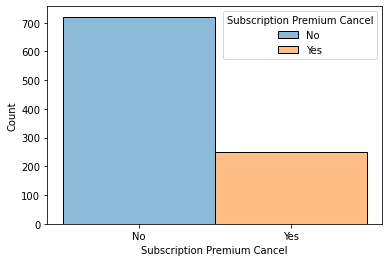

In [143]:
data = copy.deepcopy(df.drop_duplicates(subset = ["userid"]))
def for_hist(row):
    if row["Subscription Premium Cancel"] == 1:
        return "Yes"
    else:
        return "No"
#fig, ax = plt.subplots(figsize=(15,15))  
data["Subscription Premium Cancel"] = data.apply(for_hist, axis=1)
sns.histplot(data = data, x = "Subscription Premium Cancel", hue = "Subscription Premium Cancel")
plt.show()

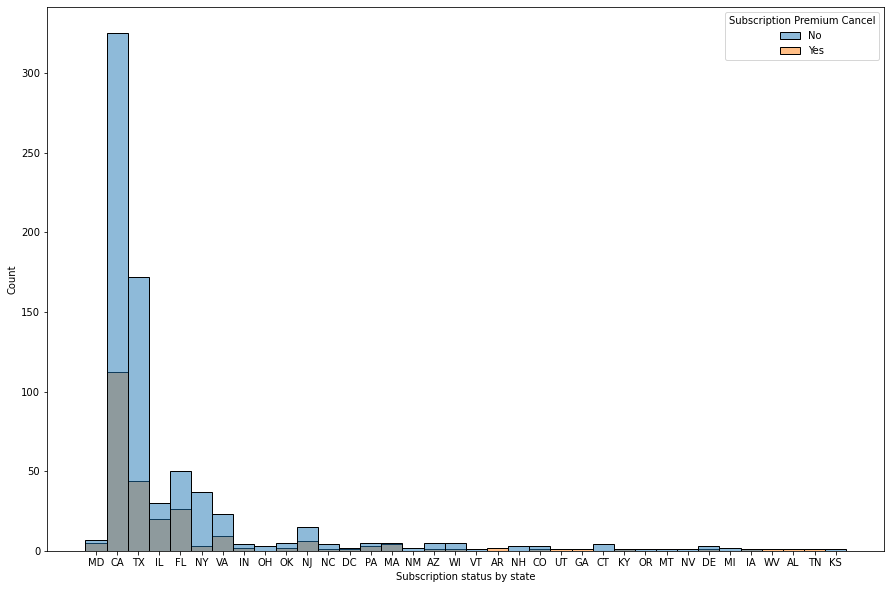

In [144]:
fig, ax = plt.subplots(figsize=(15,10))    
sns.histplot(data = data, x = "user_state", hue = "Subscription Premium Cancel")
ax.set (xlabel='Subscription status by state')
plt.show()

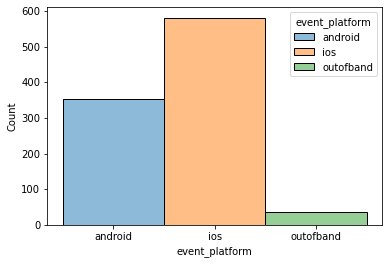

In [8]:

#fig, ax = plt.subplots(figsize=(15,10))    
sns.histplot(data = data, x = "event_platform", hue = "event_platform")
plt.show()

In [70]:
df_static_data = createdf("csv//static_data.csv")

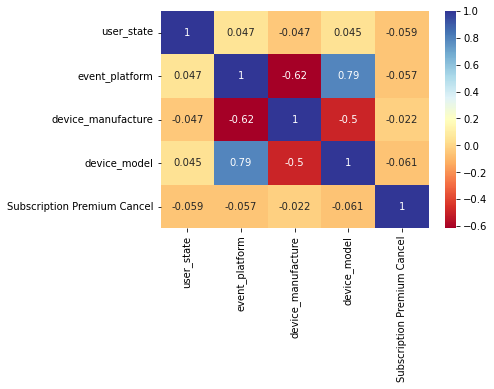

In [71]:
dataplot = sns.heatmap(df_static_data.corr(), cmap="RdYlBu", annot=True)
plt.show()

Немає ніякої кореляції із використаною платформою чи девайсом. Зі штатом прямої кореляції також немає - можливо пов'язано із великою кількістью даних по Каліфорнії та Техасу у вибірці. Відсоток відписавшихся в різних штатах є різним.

In [81]:
df_state = createdf("csv//feature_per_state.csv")

In [85]:

df_state[["user_state", "cancel_percentage"]].transpose()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
user_state,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,OK,OR,PA,TN,TX,UT,VA,VT,WI,WV
cancel_percentage,1.0,1.0,0.042453,0.377438,0.55,0.0,0.705882,0.058824,0.301661,1.0,...,0.376471,0.0,0.387597,1.0,0.195059,1.0,0.420712,0.0,0.056338,1.0


In [11]:
df_date = createdf("csv//event_and_date_data.csv")

In [12]:
df_error_rate = createdf("csv//error_data.csv")
df_error_rate = df_error_rate.iloc[: , :-5]


Є невелика кореляція з невдалими спробами додати оплату. 

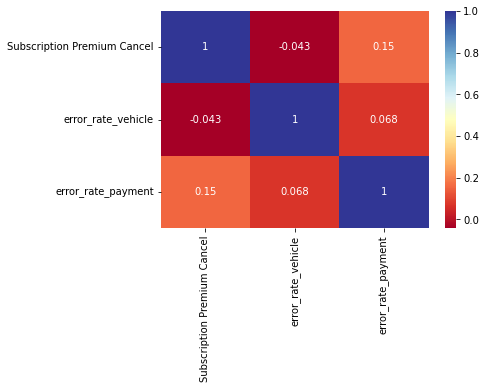

In [128]:
dataplot = sns.heatmap(df_error_rate.corr(), cmap="RdYlBu", annot=True)
plt.show()

Існує невеличка кореляція відміни підписки з подією Add Payment Method Failed 

In [120]:
subscription_check = createdf("csv//subscription_check.csv")

Всі підписки оформлювалися лише на рік

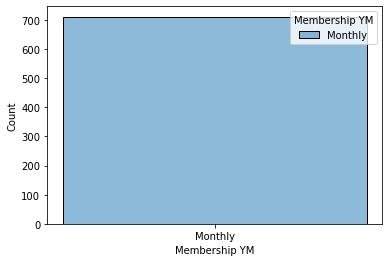

In [121]:
data = copy.deepcopy(subscription_check.drop_duplicates(subset = ["userid"]))
def for_hist(row):
    if row["Membership YM"] == 0:
        return "Monthly"
    else:
        return "Yearly"

data["Membership YM"] = data.apply(for_hist, axis=1)
sns.histplot(data = data, x = "Membership YM", hue = "Membership YM")
plt.show()

In [122]:
renew_check = createdf("csv//renew_check.csv")

Більшість підписок подовжувалися на місяць

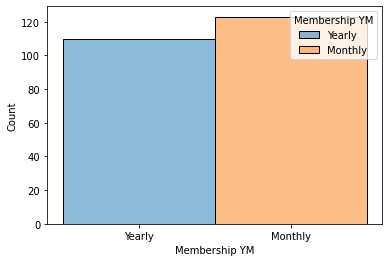

In [123]:
data = copy.deepcopy(renew_check.drop_duplicates(subset = ["userid"]))

data["Membership YM"] = data.apply(for_hist, axis=1)
sns.histplot(data = data, x = "Membership YM", hue = "Membership YM")
plt.show()

In [124]:
def event_occured_per_user(row):
    if row['userid'] in event_list:
        return 1
    else:
        return 0

In [125]:
subscription_check = subscription_check.drop(['Membership YM'], axis = 1)
events = ["Chat Conversation Opened", "Chat Conversation Started", "Transaction Refund"]
for i in events:
    event = i
    df_temp = df[df["event_name"] == event]
    event_list = df_temp["userid"].unique()
    renew_check[event] = renew_check.apply(event_occured_per_user, axis=1)
    subscription_check[event] = subscription_check.apply(event_occured_per_user, axis=1)

Матриці кореляцій подій та їх відстані від припинення підписки із подією припинення підписки

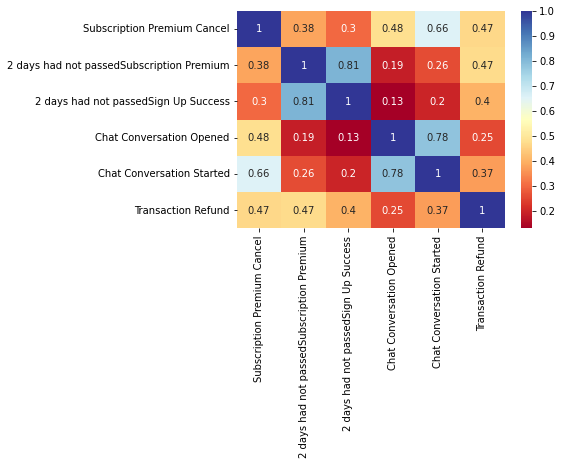

In [163]:

dataplot = sns.heatmap(subscription_check.corr(), cmap="RdYlBu", annot=True)
plt.show()

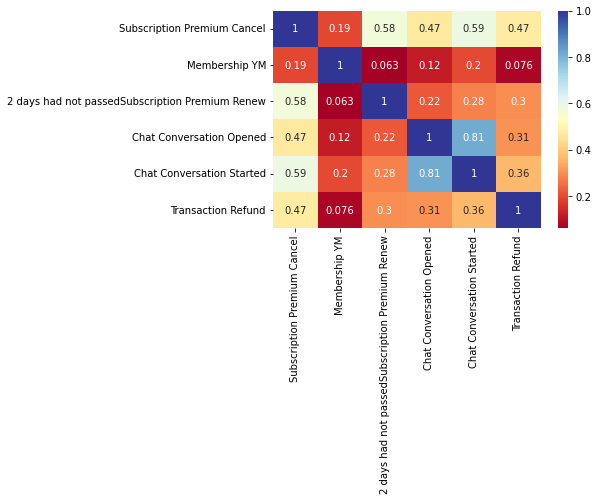

In [164]:
dataplot = sns.heatmap(renew_check.corr(), cmap="RdYlBu", annot=True)
plt.show()

Є невелика кореляція із типом подовженої підписки. Велика кореляція із зверненням в підтримку та із фактом подовження підписки за останні два дні.

In [47]:
datetime_df = createdf("csv//event_and_date_data.csv")

In [42]:
df_datehist = datetime_df[datetime_df["Subscription Premium Cancel"]==1]

In [43]:
def weekday(row):
    return(week_days[row["day_week"]])

In [44]:
week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_datehist["week_day"] = df_datehist.apply(weekday, axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_4248\1616497938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_datehist["week_day"] = df_datehist.apply(weekday, axis=1)


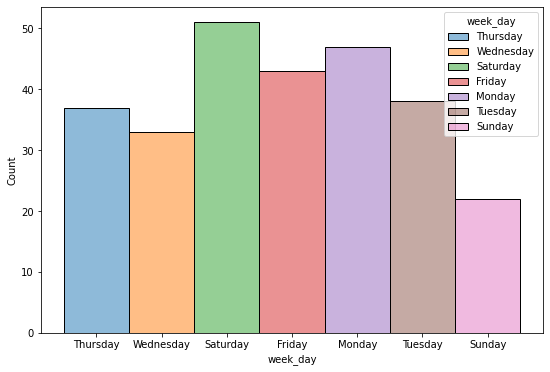

In [51]:
fig, ax = plt.subplots(figsize=(9,6)) 
sns.histplot(data = df_datehist, x = "week_day", hue = "week_day")
plt.show()

Найбільше відписок було у суботу та понеділок, але набір даних замалий аби щось за ними сказати

Висновок: найменш корельованими показниками є девайс, його виробник та події які виконувались всіми користувачами, найбільш впливовими - наявність замовлень та звернення в підтримку. Більшість відписок трапляється або після автоматичного подовження підписки (яке зазвичай є подовженням на рік) або одразу після оформлення підписки. Також трохи впливає помилка додавання способу оплати.

Спробуємо більшість з цих характеристик перевірити на важливість за допомогою дерева рішень та лінійної регресії

In [94]:

df_ultimate = createdf("csv//df_all.csv")
df_ultimate = df_ultimate.drop(['userid','event_name', 'event_attributes', 'event_created_date', 
                                'last date Subscription Premium Cancel', 'last date Subscription Premium Renew',
                                'last date Subscription Premium' , 'last date Order'], axis = 1)

In [145]:
def j_max(feat, j):
    rows = feat.shape[0]
    indexes = [(e//rows, e-(e//rows * rows)) 
                for e in  feat.flatten().argsort()[::-1][:j]]
    return indexes


In [137]:
def j_min(feat, j):
    rows = feat.shape[0]
    indexes = [(e//rows, e-(e//rows * rows)) 
                for e in  feat.flatten().argsort()[:j]]
    return indexes


In [95]:
df_ultimate.columns

Index(['user_state', 'event_platform', 'device_manufacture', 'device_model',
       'Subscription Premium Cancel', 'Add Payment Method Success',
       'Subscription Premium', 'Account History Transaction Details',
       'Add Vehicle Success', 'Subscription Premium Renew', 'Sign Up Success',
       'Order', 'Chat Conversation Opened', 'Add Vehicle Break',
       'Chat Conversation Started', 'Email Confirmation Success',
       'Add Payment Method Failed', 'Account Setup Skip', 'Calculator View',
       'Wallet Opened', 'Account Setup Profile Skip', 'Sign Out',
       'Transaction Refund', 'Calculator Used', 'Add Vehicle Failed',
       'Sign Up Error', 'Reset Password Set', 'Membership Ren',
       '2 days had not passedSubscription Premium Renew', 'Membership Sub',
       '2 days had not passedSubscription Premium', 'delta monthsOrder'],
      dtype='object')

In [97]:
x = copy.deepcopy(df_ultimate.drop(['Subscription Premium Cancel'], axis = 1))

In [98]:
y = copy.deepcopy(df_ultimate['Subscription Premium Cancel'])

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Регресія:

In [160]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(x, y)
features = regression.coef_

indexes = j_max(features, 5)
for i in indexes:
    print(x.columns[i[1]] + " : "  +str(features[i[1]]))
    

Chat Conversation Started : 0.4402753735703195
2 days had not passedSubscription Premium Renew : 0.40678423949533227
Subscription Premium Renew : 0.32443834778049807
Transaction Refund : 0.22003240152991094
2 days had not passedSubscription Premium : 0.17996629533848013


In [161]:

indexes = j_min(features, 5)
for i in indexes:
    print(x.columns[i[1]] + " : "  +str(features[i[1]]))

delta monthsOrder : -0.254977738670444
Add Vehicle Success : -0.10267256297466971
Calculator View : -0.0905519100549325
Chat Conversation Opened : -0.08371569101605476
Add Payment Method Success : -0.058262066608947664


І лісом:

In [103]:
forest = RandomForestClassifier()
param_grid={'n_estimators':[1,2,5,10],'max_depth':[2,8,10],'min_samples_leaf': 
[1,2,4]}

In [104]:
grid = GridSearchCV(forest, param_grid).fit(x, y)


print(grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 10}


In [109]:
forest = RandomForestClassifier(max_depth= 10, min_samples_leaf= 4, n_estimators= 10)
forest.fit(x,y)



RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=10)

In [115]:

for i in range(len(x.columns)):
    print(x.columns[i] + " : "  +str(forest.feature_importances_[i]))

user_state : 0.012673712598775911
event_platform : 0.004845580012447471
device_manufacture : 0.013486301817469869
device_model : 0.024095989882949167
Add Payment Method Success : 0.0013447209511318506
Subscription Premium : 0.022224029308715473
Account History Transaction Details : 0.014087781780293433
Add Vehicle Success : 0.008848268467377142
Subscription Premium Renew : 0.0043539106459899715
Sign Up Success : 0.0007047228947361356
Order : 0.04266012350561636
Chat Conversation Opened : 0.03948684940096739
Add Vehicle Break : 0.000992888729771293
Chat Conversation Started : 0.22284618288906746
Email Confirmation Success : 0.0018356530833852514
Add Payment Method Failed : 0.00047767678230650957
Account Setup Skip : 0.0037847914170971507
Calculator View : 0.005603881103762413
Wallet Opened : 0.045186330797144944
Account Setup Profile Skip : 0.005445086717079966
Sign Out : 0.009380358957644452
Transaction Refund : 0.08063763810038405
Calculator Used : 1.3688670138904933e-05
Add Vehicle F

In [155]:
indexes = j_max(forest.feature_importances_, 15)
for i in indexes:
    print(x.columns[i[1]] + " : "  +str(forest.feature_importances_[i[1]]))

delta monthsOrder : 0.36368062127612616
Chat Conversation Started : 0.22284618288906746
Transaction Refund : 0.08063763810038405
Wallet Opened : 0.045186330797144944
Order : 0.04266012350561636
Chat Conversation Opened : 0.03948684940096739
device_model : 0.024095989882949167
Subscription Premium : 0.022224029308715473
Membership Sub : 0.021353200843058598
2 days had not passedSubscription Premium Renew : 0.020787391131052643
2 days had not passedSubscription Premium : 0.016987039095551906
Account History Transaction Details : 0.014087781780293433
device_manufacture : 0.013486301817469869
user_state : 0.012673712598775911
Membership Ren : 0.012175579139958207


In [147]:

indexes = j_min(forest.feature_importances_, 15)
for i in indexes:
    print(x.columns[i[1]] + " : "  +str(forest.feature_importances_[i[1]]))

Reset Password Set : 0.0
Sign Up Error : 0.0
Add Vehicle Failed : 0.0
Calculator Used : 1.3688670138904933e-05
Add Payment Method Failed : 0.00047767678230650957
Sign Up Success : 0.0007047228947361356
Add Vehicle Break : 0.000992888729771293
Add Payment Method Success : 0.0013447209511318506
Email Confirmation Success : 0.0018356530833852514
Account Setup Skip : 0.0037847914170971507
Subscription Premium Renew : 0.0043539106459899715
event_platform : 0.004845580012447471
Account Setup Profile Skip : 0.005445086717079966
Calculator View : 0.005603881103762413
Add Vehicle Success : 0.008848268467377142
